In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import typing

In [3]:
%watermark -diwmuv -iv

Last updated: 2025-11-06T19:14:58.798154+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1036-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

seaborn: 0.13.2
scipy  : 1.14.1
numpy  : 2.1.2
pandas : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-09-07-shortcut-naive-comparison"
teeplot_subdir

'2025-09-07-shortcut-naive-comparison'

## Prep Data


Data generated with the following command in the `hstrat` directory:

```sh
python3 examples/end2end_tree_reconstruction_test.py --skip-vis --no-preset-random --repeats 40 --reconstruction-algo shortcut naive --differentia-bitwidth 64 8 1 --surface-size 256 32 16
```

In [5]:
!curl -L https://osf.io/download/7j3t4/ -o /tmp/data.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   357  100   357    0     0    746      0 --:--:-- --:--:-- --:--:--   746
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  130k  100  130k    0     0  92119      0  0:00:01  0:00:01 --:--:--  928k


In [6]:
reconstruction_error_data = pd.read_csv("/tmp/data.csv")
reconstruction_error_data.head()

,Unnamed: 0,differentia_bitwidth,surface_size,fossil_interval,error,error_dropped_fossils,reconstruction_algorithm
0,720,64,256,200.0,0.005871,0.005764,shortcut
1,721,64,256,200.0,0.007744,0.005615,shortcut
2,722,64,256,200.0,0.004145,0.011144,shortcut
3,723,64,256,200.0,0.002127,0.007910,shortcut
4,724,64,256,200.0,0.013993,0.043643,shortcut


### Power Analysis

Assuming the null hypothesis for a given sample size and significance level, finds the lowest number $x$ such that $$P(\text{positives} \le x) \ge 0.80$$ Hypothetically, this means that, given a certain effect size, the difference is reliably detected (80% of the time) if the number of positives is greater than this number.

In [7]:
def compute_expected_positive_rate(
    num_trials: int, significance: float
) -> int:
    for i in range(num_trials + 1):
        if scipy.stats.binom.cdf(i, num_trials, significance) >= 0.80:
            return i


compute_expected_positive_rate(27, 0.05)

2

#### Determining the effect size

In [8]:
def min_detected_effect_size(
    significance: float,
    *,
    num_tests: int = 10,
    sample_size: typing.Optional[int] = None
) -> float:
    for multiplier in np.linspace(0, 1, 51):
        positives = 0
        for _ in range(num_tests):
            groups = reconstruction_error_data.groupby(
                ["differentia_bitwidth", "surface_size", "fossil_interval"]
            )
            for _, df in groups:
                example_data = df[
                    df["reconstruction_algorithm"] == "shortcut"
                ]["error_dropped_fossils"].to_numpy()
                if sample_size is not None:
                    num_repeats = int(np.ceil(sample_size / example_data.size))
                    example_data = example_data.repeat(num_repeats)[
                        :sample_size
                    ]
                _, p = scipy.stats.mannwhitneyu(
                    example_data,
                    example_data
                    + np.random.uniform(size=example_data.size)
                    * example_data.mean()
                    * multiplier,
                    alternative="two-sided",
                )

                if p < significance:
                    positives += 1
        if positives / num_tests > compute_expected_positive_rate(
            len(groups), significance
        ):
            return {
                "effect_size": float(multiplier),
                "sample_size": example_data.size,
            }


min_detected_effect_size(0.05, sample_size=40)

{'effect_size': 0.36, 'sample_size': 40}

### Running initial statistical test

From the power analysis, we know that if there are more than 3 positives then we have a significant difference. We also know that this is capable of detecting a difference of around 0.34 (with a sample size of 40).

Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth=64, surface_size=32, fossil_interval=200.0


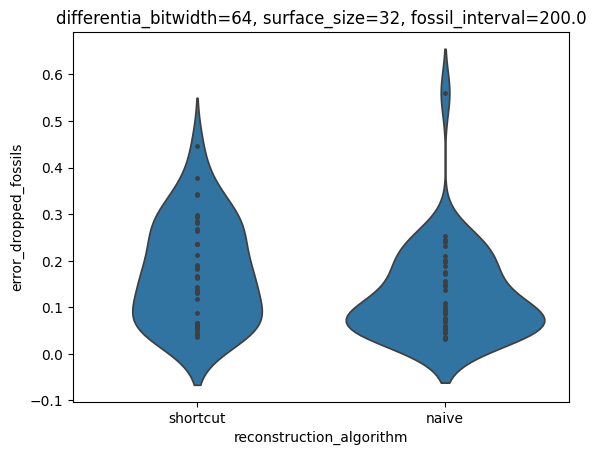

In [9]:
for info, df in reconstruction_error_data.groupby(
    ["differentia_bitwidth", "surface_size", "fossil_interval"]
):
    stat, p = scipy.stats.mannwhitneyu(
        df[df["reconstruction_algorithm"] == "shortcut"][
            "error_dropped_fossils"
        ],
        df[df["reconstruction_algorithm"] == "naive"]["error_dropped_fossils"],
        alternative="two-sided",
    )

    if p < 0.05:
        print(
            f"Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth={info[0]}, surface_size={info[1]}, fossil_interval={info[2]}"
        )
        sns.violinplot(
            data=df,
            x="reconstruction_algorithm",
            y="error_dropped_fossils",
            inner="point",
            split=False,
        ).set_title(
            f"differentia_bitwidth={info[0]}, surface_size={info[1]}, fossil_interval={info[2]}"
        )

### Detecting Smaller Differences

To detect even smaller effect sizes, we need to increase the sample size.

In [10]:
def min_sample_size_for_effect_size(effect_size: float, significance: float):
    for sample_size in range(100, 500, 20):
        detected_effect_size = min_detected_effect_size(
            significance, sample_size=sample_size
        )
        if detected_effect_size["effect_size"] <= effect_size:
            return detected_effect_size["sample_size"]


min_sample_size_for_effect_size(0.10, 0.05)

240

## Test with even more data

Data generated with the following command in the `hstrat` directory:

```sh
python3 examples/naive_shortcut_comparison_data_generation.sh 64 256
```

In [11]:
!curl -L https://osf.io/download/9cwte -o /tmp/data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   247  100   247    0     0    592      0 --:--:-- --:--:-- --:--:--   590
100   357  100   357    0     0    673      0 --:--:-- --:--:-- --:--:--   673
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 4384k  100 4384k    0     0  1828k      0  0:00:02  0:00:02 --:--:-- 34.3M


In [12]:
reconstruction_error_data = pd.read_csv("/tmp/data.csv")
reconstruction_error_data.head()

,differentia_bitwidth,surface_size,fossil_interval,error,error_dropped_fossils,reconstruction_algorithm,retention_algorithm
0,64,256,200.0,0.018248,0.075603,shortcut,dstream.hybrid_0_steady_1_tiltedxtc_2_algo
1,64,256,200.0,0.010613,0.000445,naive,dstream.hybrid_0_steady_1_tiltedxtc_2_algo
2,8,256,200.0,0.000061,0.000241,shortcut,dstream.hybrid_0_steady_1_tiltedxtc_2_algo
3,8,256,200.0,0.015017,0.001750,naive,dstream.hybrid_0_steady_1_tiltedxtc_2_algo
4,1,256,200.0,0.011957,0.006747,shortcut,dstream.hybrid_0_steady_1_tiltedxtc_2_algo


### Recompute the number of positives we need to see to detect a difference



In [13]:
compute_expected_positive_rate(len(reconstruction_error_data.groupby(
    ["differentia_bitwidth", "surface_size", "fossil_interval", "retention_algorithm"]
)), 0.05)

7

Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth=1, surface_size=32, fossil_interval=50.0
Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth=1, surface_size=256, fossil_interval=50.0
Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth=8, surface_size=32, fossil_interval=200.0


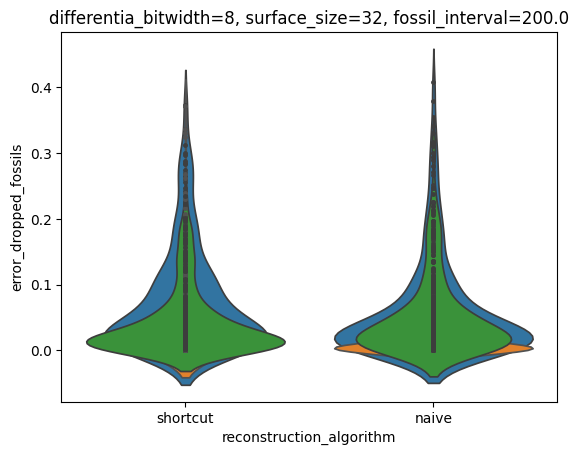

In [14]:
for info, df in reconstruction_error_data.groupby(
    ["differentia_bitwidth", "surface_size", "fossil_interval", "retention_algorithm"]
):
    stat, p = scipy.stats.mannwhitneyu(
        df[df["reconstruction_algorithm"] == "shortcut"][
            "error_dropped_fossils"
        ],
        df[df["reconstruction_algorithm"] == "naive"]["error_dropped_fossils"],
        alternative="two-sided",
    )

    if p < 0.05:
        print(
            f"Significant difference in reconstruction error between shortcut and naive for differentia_bitwidth={info[0]}, surface_size={info[1]}, fossil_interval={info[2]}"
        )
        sns.violinplot(
            data=df,
            x="reconstruction_algorithm",
            y="error_dropped_fossils",
            inner="point",
            split=False,
        ).set_title(
            f"differentia_bitwidth={info[0]}, surface_size={info[1]}, fossil_interval={info[2]}"
        )